In [1]:
# @title Imports external sources
#  conda activate py310_ICL
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
import io
from IPython.display import display
import PIL.Image, PIL.ImageDraw, PIL.ImageFont
import base64
import zipfile
import json
import requests
import matplotlib.pylab as pl
import numpy as np
import glob
import requests
import random as pyrandom
from concurrent import futures
from functools import partial
from scipy.ndimage import rotate
from IPython.display import Image, HTML, clear_output
from tqdm import tqdm_notebook, tnrange
import time
from typing import Any, MutableMapping, NamedTuple, Tuple

import jax
from jax import grad, jit, vmap
import jax.numpy as jnp

import haiku as hk
import math

from ml_collections import config_dict
import matplotlib.pylab as pl
import matplotlib.colors as mcolors

colors = pl.colormaps['Dark2']
from src.transformer import Transformer
from src.data import create_reg_data_classic_token, create_weights
from src.config import config
from src.train import *


In [2]:

# @title Config
softmax = False  # @param {type:"boolean"}
layernorm = False  # @param {type:"boolean"}

recurrent_Transformer = True  # @param {type:"boolean"}
num_layers = 5 # @param {type:"integer"}
num_heads = 1  # @param {type:"integer"}
num_seeds = 1  # @param {type:"integer"}

config.seed = 0
config.local_usage = True

####
config.deq = recurrent_Transformer
config.gd_deq = recurrent_Transformer
config.att_only_trans = True
####

config.pre_train_gd = True
config.train_gd_whitening = True
config.train_gd_lr = True
config.use_bias = False
config.include_query = False

config.distract_size = 0
config.training_steps =8000 if config.deq else 8000
config.training_steps_gd = 1000 if config.gd_deq else 30000
config.use_softmax = softmax
config.first_layer_sm = False
config.use_non_lin_mix = False

config.widening_factor = 4

config.layer_norm = layernorm
config.out_proj = False
config.in_proj = False
config.adam = True
config.dataset_size = 10
config.input_size = 10

"""------------------need to change----------"""
document_num=1
config.key_size = 11+(config.dataset_size*document_num)   
config.num_layers = num_layers
config.num_heads = num_heads

config.grad_clip_value = 10 if num_layers > 2 else 0.001
config.grad_clip_value_gd = 10 if num_layers > 2 else 0.001
config.lr = 0.0005# if num_layers > 3 else 0.001
config.gd_lr = 0.0005# if num_layers > 3 else 0.001
config.wd = 0.0
config.init_scale = 0.002 / config.num_layers
config.bs = 2048
config.bs_gd_train = 512
config.dampening = 1.0
config.clip = 10 if num_layers > 3 else 0

config.dropout_rate = 0.0
data_creator = vmap(create_reg_data,
                    in_axes=(0, None, None, None, None, None),
                    out_axes=0)

config.y_update = False
config.input_range = 1


config.pos_enc = False
config.pos_enc_size = 20
config.concat_pos_enc = False
config.analyse = True

config.cycle_data = 0  # 0 means online learning
config.num_seeds = num_seeds
if config.num_layers == 1:
    assert config.deq == True
    assert config.gd_deq == True

if config.num_layers > 1:
    assert config.y_update == False

config.in_proj = False
config.emb_size = 11

# @title Utils
pl.rcParams.update({'font.size': 12})
pl.rc('axes', labelsize=14)
pl.rcParams.update({
    "text.usetex": False,
})

import matplotlib.colors as mcolors

colors = pl.colormaps['Dark2']

In [3]:
import sys
print(sys.version)

3.10.18 | packaged by conda-forge | (main, Jun  4 2025, 14:45:41) [GCC 13.3.0]


In [4]:


def np2pil(a):
    if a.dtype in [np.float32, np.float64]:
        a = np.uint8(np.clip(a, 0, 1) * 255)
    return PIL.Image.fromarray(a)


def imwrite(f, a, fmt=None):
    a = np.asarray(a)
    if isinstance(f, str):
        fmt = f.rsplit('.', 1)[-1].lower()
        if fmt == 'jpg':
            fmt = 'jpeg'
        f = open(f, 'wb')  # GFile.open(f, 'wb')
    np2pil(a).save(f, fmt, quality=95)


def imencode(a, fmt='jpeg'):
    a = np.asarray(a)
    if len(a.shape) == 3 and a.shape[-1] == 4:
        fmt = 'png'
    f = io.BytesIO()
    imwrite(f, a, fmt)
    return f.getvalue()


def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


def grab_plot(close=True):
    """Return the current Matplotlib figure as an image."""
    fig = pl.gcf()
    fig.canvas.draw()
    img = np.array(fig.canvas.renderer._renderer)
    a = np.float32(img[..., 3:] / 255.0)
    img = np.uint8(255 * (1.0 - a) + img[..., :3] * a)  # alpha
    if close:
        pl.close()
    return img


def display_learning(train, test=None, gt=None, inter=None, title="train",
                     title1="Trained TF", title2="Test",
                     title3='Gradient descent', title4='Interpolated',
                     y_label1='L2 Norm', y_label2='Cosine sim',
                     y_lim_l=0, y_lim_u=1, single_seeds=False,
                     plot_title=None,
                     y_lim_u2=1., y_lim_l2=0., x_label='Training steps',
                     second_axis=False, color_add=0.2, rw=10, num_iter_os=None,
                     allow_download=False, plot_num=1, two_plots=False,
                     loc_first='upper left', label_title="Loss",
                     loc_sec='upper left', yscale_log=False, line="-",
                     color_axis=True,
                     height=3.5, width=4, ax1=None, ax2=None):
    """Update learning curve image."""
  
    train_list = train
    train = np.array(train)
    num_seeds_train = train.shape[0]
    train_std = np.std(train, axis=0)
    train = np.mean(train, axis=0)

    if test is not None:
        test_list = test
        test_std = np.std(test, axis=0)
        test = np.mean(test, axis=0)

    if gt is not None:
        gt_list = gt
        gt_std = np.std(gt, axis=0)
        gt = np.mean(gt, axis=0)

    if inter is not None:
        inter_list = inter
        inter_std = np.std(inter, axis=0)
        inter = np.mean(inter, axis=0)

    if plot_num == 1:
        fig, ax1 = pl.subplots()
        ax1.set_xlabel(x_label,fontsize=14)
        ax1.tick_params(axis='both', labelsize=14) 
        fig.set_size_inches(width, height)

    if test is not None and not second_axis:
       
        """---get in to ---------"""
        # print("num_iter_os",num_iter_os)
        x_range = np.arange(0, num_iter_os, int(num_iter_os / len(test)))  # 50
       
      
        if len(test_list) > 1:
            if single_seeds:
                for s in test_list:
                    ax1.plot(x_range, s, color=colors(0.1 + color_add), alpha=0.2, label=title2, linewidth='2')
            else:
                ax1.fill_between(x_range, test - test_std, test + test_std, alpha=0.2,
                                 facecolor=colors(0.1 + color_add))
        ax1.plot(x_range, test, color=colors(0.1 + color_add), label=title2, linewidth='3')
        # test_avg = moving_average(test, rw)
        # ax1.plot(x_range[:len(test_avg)], test_avg, color=colors(0.1+color_add), label=title2)

    if gt is not None:
        if not second_axis:
            x_range = np.arange(0, num_iter_os, int(num_iter_os / len(gt)))
            # ax1.plot(x_range[:len(gt[:-rw])], gt[:-rw], color=colors(0.2+color_add), alpha=0.3)
            # gt_avg = moving_average(gt, rw)
            ax1.plot(x_range, gt, color=colors(0.2 + color_add), label=title3, linewidth='3')
            if len(gt_list) > 1:
                if single_seeds:
                    for s in gt_list:
                        ax1.plot(x_range, s, color=colors(0.2 + color_add), alpha=0.2, linewidth='2', zorder=0)
                else:
                    ax1.fill_between(x_range, gt - gt_std, gt + gt_std, alpha=0.2, facecolor=colors(0.2 + color_add))
        else:
            x_range = np.arange(0, num_iter_os, int(num_iter_os / len(gt)))
            ax1.plot(x_range, gt, color=colors(0.6 + color_add), label=title3, linewidth='3')
            if len(gt_list) > 1:
                if single_seeds:
                    for s in gt_list:
                        ax1.plot(x_range, s, color=colors(0.6 + color_add), alpha=0.3, linewidth='2', zorder=0)
                else:
                    ax1.fill_between(x_range, gt - gt_std, gt + gt_std, alpha=0.2, facecolor=colors(0.6 + color_add))

    if test is not None and second_axis:
        x_range = np.arange(0, num_iter_os, int(num_iter_os / len(test)))
     
        ax1.plot(x_range, test, color=colors(0.5 + color_add), label=title2, linewidth='3')
        # test_avg = moving_average(test, rw)
        # ax1.plot(x_range[:len(test_avg)],test_avg, color=colors(0.5+color_add))
        if len(test_list) > 1:
            if single_seeds:
                for s in test_list:
                    ax1.plot(x_range, s, color=colors(0.5 + color_add), linewidth='2', alpha=0.3, zorder=0)
            else:
                ax1.fill_between(x_range, test - test_std, test + test_std, alpha=0.2,
                                 facecolor=colors(0.5 + color_add))

    if inter is not None and not second_axis:
        x_range = np.arange(0, num_iter_os, int(num_iter_os / len(inter)))
        ax1.plot(x_range, inter, color=colors(0.4 + color_add), label=title4, linewidth='3', zorder=10)
        if len(inter_list) > 1:
            if single_seeds:
                for s in inter_list:
                    ax1.plot(x_range, s, color=colors(0.4 + color_add), alpha=0.3, linewidth='2', zorder=0)
            else:
                ax1.fill_between(x_range, inter - inter_std, inter + inter_std, alpha=0.2,
                                 facecolor=colors(0.4 + color_add), zorder=1)
        # inter_avg = moving_average(inter, rw)
        # ax1.plot(x_range[:len(inter_avg)], inter_avg, color=colors(0.7+color_add), label=title4)
    """

    the label of model cos 
    """
    if second_axis:   
        if ax2 is None:
            ax2 = ax1.twinx()
        ax2.set_zorder(0)
        ax1.set_zorder(1)
        ax1.set_frame_on(False)
        # train_avg = moving_average(train, rw)
        # ax2.plot(train[:-rw], color=colors(0.1+color_add), alpha=0.3)
        ax2.plot(x_range, train, color=colors(0.4 + color_add), label=title1, linewidth='3')
        ax2.plot(x_range, np.ones_like(train), "--", color="gray", linewidth='0.7')
        # legend2 = ax2.legend(loc='upper right', framealpha=0.5, facecolor='white')
        # legend2.set_zorder(100)
        if len(train_list) > 1:
            if single_seeds:
                for s in train_list:
                    print(x_range, s)
                    ax1.plot(x_range, s, line, color=colors(0.4 + color_add), alpha=0.3, linewidth='2', zorder=0)
            else:
                ax2.fill_between(x_range, train - train_std, train + train_std, alpha=0.2,
                                 facecolor=colors(0.4 + color_add))

        if color_axis:
            ax2.yaxis.label.set_color(colors(0.4 + color_add))
        # else:
        #     legend2 = ax2.legend(loc='upper right', framealpha=0.99, facecolor='white')
        #     legend2.set_zorder(100)
            
        ax2.set_ylabel(y_label2, color="black",fontsize=14)
        ax1.tick_params(axis='both', labelsize=14) 
        ax2.spines['top'].set_visible(False)
    else:
        ax1.spines['right'].set_visible(False)
        # train_avg = moving_average(train, rw)
        if line != "-":
            ax1.scatter(x_range, train, s=[100 for _ in x_range],
                        marker="+", color=colors(0.3 + color_add), alpha=1, label=title1, zorder=3, linewidths=3)
        else:
            ax1.plot(x_range, train, line, color=colors(0.3 + color_add), label=title1, linewidth='3', zorder=11)
        # ax1.plot(x_range[:len(train_avg)], train_avg, line, color=colors(0.3+color_add), label=title1)
        if len(train_list) > 1:
            if single_seeds:
                for s in train_list:
                    ax1.plot(x_range, s, line, color=colors(0.3 + color_add), alpha=0.3, linewidth='2', zorder=0)
            else:
                ax1.fill_between(x_range, train - train_std, train + train_std,
                                 alpha=0.5, facecolor=colors(0.3 + color_add))

        # ax1.legend(loc='best', framealpha=1, facecolor='white')
        # ax1.spines['right'].set_visible(False)
        # legend = ax1.legend(loc='upper right', framealpha=0.99, facecolor='white')
        # legend.set_zorder(100)

    # legend1 = ax1.legend(loc=loc_first, framealpha=0.99, facecolor='white')
    # legend1.set_zorder(100)
    if second_axis:
        ax2.set_ylabel(y_label2,fontsize=14)
        ax1.tick_params(axis='both', labelsize=14) 
        ax1.set_ylabel(y_label1,fontsize=14)
        ax1.tick_params(axis='both', labelsize=14) 
        ax1.set_ylim(y_lim_l, y_lim_u)
        # legend1 = ax1.legend(loc=loc_sec, framealpha=0.99, facecolor='white')
        # ax2.set_ylim(y_lim_l2, y_lim_u2)
        # ax1.set_ylim(bottom=0)
    else:
        ax1.set_ylabel(label_title, fontsize=14)
    # pl.ylim(y_lim_l, y_lim_u)
        pl.ylim(y_lim_l, y_lim_u)
    ax1.spines['top'].set_visible(False)
    """---adding new--------"""
    handles1, labels1 = ax1.get_legend_handles_labels()
    if second_axis:
        handles2, labels2 = ax2.get_legend_handles_labels()
        handles = handles1 + handles2
        labels = labels1 + labels2
    else:
        handles, labels = handles1, labels1
    """---------"""
    legend = ax1.legend(handles, labels,
                    loc='upper center',
                    bbox_to_anchor=(0.5, 1.25),   # 图例在上方
                    ncol=3,                      
                    framealpha=0.9,
                    facecolor='white',
                    fontsize=10,
                    handlelength=1.5,   # 控制线段长度 (默认 2)
                    handletextpad=0.5   # 线段与文字间距
                   )
    legend.set_zorder(100)


    if second_axis:   
        ax2.set_ylabel(y_label2, fontsize=10, color="black")
        ax1.set_ylabel(y_label1, fontsize=10)
        # if ax2 is None:
        #     ax2 = ax1.twinx()
        ax2.set_zorder(0)
        ax1.set_zorder(1)
        ax1.set_frame_on(False)


    
        # 右侧曲线
        ax2.plot(x_range, train, color=colors(0.4 + color_add),
                 label=title1, linewidth='3')
        ax2.plot(x_range, np.ones_like(train), "--", color="gray", linewidth='0.7')
    
        legend2 = ax2.legend(loc='upper right', framealpha=0.5,
                             facecolor='white', fontsize=14)
        legend2.set_zorder(100)
        ax2.get_legend().remove()
        if len(train_list) > 1:
            if single_seeds:
                for s in train_list:
                    ax1.plot(x_range, s, line, color=colors(0.4 + color_add),
                             alpha=0.3, linewidth='2', zorder=0)
            else:
                ax2.fill_between(x_range, train - train_std, train + train_std,
                                 alpha=0.2, facecolor=colors(0.4 + color_add))
    
        # 坐标轴标题字体
        ax1.set_ylabel(y_label1, fontsize=14)                 # 左边标题
        ax2.set_ylabel(y_label2, color="black", fontsize=14)  # 右边标题
    
        # 刻度字体大小
        ax1.tick_params(axis='both', labelsize=14)  # 左边 y + x
        ax2.tick_params(axis='y', labelsize=14)     # 右边 y




    
    if plot_title is not None:
        pl.title(plot_title)

    if yscale_log:
        ax1.set_yscale("log")
    # pl.title(title)
    pl.tight_layout()

    if allow_download:
        if second_axis:
            pl.savefig(title, format="pdf")
            # % download_file
            # sim.pdf
        else:
            pl.savefig(title, format="pdf")
            # % download_file
            # train.pdf
    else:
        img = grab_plot()
        display(Image(data=imencode(img, fmt='jpeg')), display_id=title)


In [5]:

# @title Lists

loss_trans_list = [[] for _ in range(config.num_seeds)]
loss_trans_train_list = [[] for _ in range(config.num_seeds)]
losses_gd_list = [[] for _ in range(config.num_seeds)]
losses_gd_list_trained = [[] for _ in range(config.num_seeds)]
losses_int_list_trained = [[] for _ in range(config.num_seeds)]
cos_sim_list, cos_sim_list_o = [[] for _ in range(config.num_seeds)], [[] for _ in range(config.num_seeds)]
grad_norm_list, grad_norm_list_o = [[] for _ in range(config.num_seeds)], [[] for _ in range(config.num_seeds)]
p_norm_list, p_norm_list_o = [[] for _ in range(config.num_seeds)], [[] for _ in range(config.num_seeds)]

cos_sim_list, cos_sim_list_o = [[] for _ in range(config.num_seeds)], [[] for _ in range(config.num_seeds)]
grad_norm_list, grad_norm_list_o = [[] for _ in range(config.num_seeds)], [[] for _ in range(config.num_seeds)]
p_norm_list, p_norm_list_o = [[] for _ in range(config.num_seeds)], [[] for _ in range(config.num_seeds)]

ir_t_list = [[] for _ in range(config.num_seeds)]
ws_t_list = [[] for _ in range(config.num_seeds)]
ir_gd_list = [[] for _ in range(config.num_seeds)]
ws_gd_list = [[] for _ in range(config.num_seeds)]

ir_t_ood_list = [[] for _ in range(config.num_seeds)]
ws_t_ood_list = [[] for _ in range(config.num_seeds)]
ir_gd_ood_list = [[] for _ in range(config.num_seeds)]
ws_gd_ood_list = [[] for _ in range(config.num_seeds)]

ir_gd_trained_list = [[] for _ in range(config.num_seeds)]
ws_gd_trained_list = [[] for _ in range(config.num_seeds)]
ir_gd_ood_trained_list = [[] for _ in range(config.num_seeds)]
ws_gd_ood_trained_list = [[] for _ in range(config.num_seeds)]

ir_inter_list = [[] for _ in range(config.num_seeds)]
ws_inter_list = [[] for _ in range(config.num_seeds)]
ir_inter_ood_list = [[] for _ in range(config.num_seeds)]
ws_inter_ood_list = [[] for _ in range(config.num_seeds)]

losses_noisy_list = [[] for _ in range(config.num_seeds)]
losses_gd_noisy_list = [[] for _ in range(config.num_seeds)]
losses_gd_noisy_trained_list = [[] for _ in range(config.num_seeds)]
losses_inter_noisy_list = [[] for _ in range(config.num_seeds)]


In [6]:

# @title Logic how to interpolate weights
def interpolate_weights(train_state, params_gd, deq=False):
    if (config.num_heads == 1 and
            config.sum_norm == False and config.deq == True and
            config.layer_norm == False and config.att_only_trans == True):

        cur_train_params = {k.replace('transformer', 'Transformer_gd'): v.copy() for
                            k, v in train_state.params.items()}

        inter_params = {k.replace('transformer', 'Transformer_gd'): {'w': jnp.zeros_like(v['w'])} for
                        k, v in train_state.params.items()}

        for k, v in cur_train_params.items():
            if "key" in k:
                key_gd = params_gd[k]['w'].copy()
                key = cur_train_params[k]['w'].copy()
            if "linear" in k:
                linear_gd = params_gd[k]['w'].copy()
                linear = cur_train_params[k]['w'].copy()
            if "query" in k:
                query_gd = params_gd[k]['w'].copy()
                query = cur_train_params[k]['w'].copy()
            if "value" in k:
                value_gd = params_gd[k]['w'].copy()
                value = cur_train_params[k]['w'].copy()

                query = jnp.matmul(query, key.T)
                # print(query)
                key = jnp.identity(query.shape[0])
                mean = np.mean([query[a, a] for a in range(query.shape[0] - 1)])
                query = query / mean
                query_gd = jnp.matmul(query_gd, key.T)
                key_gd = jnp.identity(query.shape[0])
                query = (query + query_gd) / 2

                linear = jnp.matmul(value, linear)
                # print(linear)
                value = jnp.identity(query.shape[0])
                linear = linear * mean
                linear_gd = jnp.matmul(value_gd, linear_gd)
                value_gd = jnp.identity(query.shape[0])
                linear = (linear + linear_gd) / 2

                inter_params[k.replace('value', 'linear')]['w'] = linear
                inter_params[k.replace('value', 'value')]['w'] = value
                inter_params[k.replace('value', 'query')]['w'] = query
                inter_params[k.replace('value', 'key')]['w'] = key

        losses_int, _, _ = predict_test.apply(inter_params, eval_rng, eval_data, True)
    else:
        losses_int = None
        inter_params = None
    return losses_int, inter_params

In [7]:

# @title Training

# interpolate GD and trained TF
inter = True if (config.deq and not config.use_softmax and config.num_heads == 1) else False

eval_rng = jax.random.PRNGKey(5)
for cur_seed in range(0, config.num_seeds):
    # print("-------cur_seed", cur_seed)
    config.seed = cur_seed
    optimiser, train_state, _, rng = init()
    # print(" ===nini")
    # print( train_state )
    # print(len(train_state))
    rng, data_rng = jax.random.split(rng, 2)
    if config.analyse:
        lr_min, min_loss = scan_lrs(eval_rng, lin_diag=False, bs=10000)
        if cur_seed == 0:
            print('Best lr found for ', config.num_layers, ' steps of gradient descent: ', lr_min / config.dataset_size,
                  " with loss ", min_loss)

        params_gd = create_weights(config.input_size, 1, config.dataset_size, lr_min,
                                   jax.random.normal(data_rng, shape=[1, 1, config.input_size])* 0 , # * 0
                                   lin_diag=False, gd_deq=config.gd_deq,
                                   num_layers=config.num_layers,
                                   input_mlp_rnd=rng if (config.input_mlp or config.in_proj) else None,
                                   in_proj=config.in_proj)
        # print("params_gd",params_gd)

        if config.num_layers > 1 or (config.in_proj and config.num_layers == 1):
            if cur_seed == 0:
                lr_min, min_loss = scan_lrs(eval_rng, lin_diag=True, bs=10000)
                params_init = create_weights(config.input_size, 1, config.dataset_size, lr_min,
                                             jax.random.normal(data_rng, shape=[1, 1, config.input_size])* 0, # * 0
                                             lin_diag=True, gd_deq=config.gd_deq,
                                             num_layers=config.num_layers,
                                             input_mlp_rnd=eval_rng if (config.input_mlp or config.in_proj) else None,
                                             in_proj=config.in_proj)
                params_gd_trained, data_rng = pre_train_gd_hps(eval_rng, params_init)
        else:
            params_gd_trained = params_gd
    #
    # print(" config.input_size", config.input_size)
    # print("  config.dataset_size,",  config.dataset_size)
    eval_data = data_creator(jax.random.split(eval_rng, num=10000),
                             config.input_size,
                             config.dataset_size,
                             config.size_distract,
                             config.input_range,
                             config.weight_scale)
    if config.analyse:
        # print("-----------,get in to---------")
        # # print("params_gd", params_gd)
        # print("eval_data seq",eval_data[0].shape)
        # print("eval_data target", eval_data[1].shape)
        # print("eval_data weight", eval_data[2].shape)
        #
        # """---------loss gd---------"""
        loss_gd, _, _ = predict_test.apply(params_gd, eval_rng, eval_data, True)
        loss_gd_trained, _, _ = predict_test.apply(params_gd_trained, eval_rng,
                                                   eval_data, True)


    original_data_rng = data_rng
    i=0
    for step in range(config.training_steps):
      if config.cycle_data > 0:
        if step % config.cycle_data == 0:
          data_rng = original_data_rng

      rng, data_rng = jax.random.split(data_rng, 2)
      # print("training rng99999999999",rng)
      train_data = data_creator(jax.random.split(rng, num=config.bs),
                                config.input_size,
                                config.dataset_size,
                                config.size_distract,
                                config.input_range,
                                config.weight_scale)
      # print("----before--train_state params",train_state.params)
      train_state, metrics = update(train_state, train_data, optimiser)
      if step % 100 == 0:
        """---------loss transformer---------"""
        loss_trans, _, _ = predict_test.apply(train_state.params, eval_rng,
                                              eval_data, False)
        print("-----loss_trans",loss_trans)
        loss_trans_list[cur_seed].append(loss_trans)

        loss_trans_train_list[cur_seed].append(metrics['train_loss'].item(),)
        if config.analyse:
          losses_gd_list[cur_seed].append(loss_gd)
       

          losses_int, inter_params = interpolate_weights(train_state, params_gd_trained)

          losses_int_list_trained[cur_seed].append(losses_int)

          #rng, data_rng, eval_rng = jax.random.split(data_rng, 3)
          # Alignment Transformers and GD
          cos_sim, w_norm, p_norm = analyse(eval_data, train_state, eval_rng,
                                            params_gd)
          cos_sim_o, w_norm_o, p_norm_o = analyse(eval_data, train_state, eval_rng,
                                            params_gd_trained)
          if step > 0:
            # print("loss_gd_trained.item()",loss_gd_trained.item())
            display(("Current seed", cur_seed,
                     "Training step", step, "Gradient descent loss", loss_gd.item(),
                      "GD ++ loss", loss_gd_trained.item(),
                      "Trained TF loss", loss_trans.item(),
                      "Interpolated model loss", losses_int.item() if inter else "-",
                      "Cosine sim TF vs GD", cos_sim.item(),
                      "Cosine sim TF vs GD++", cos_sim_o.item() if config.num_layers > 1 else "-"),
                      display_id="Cur met")
       
          cos_sim_list[cur_seed].append(cos_sim)
          grad_norm_list[cur_seed].append(w_norm)
          p_norm_list[cur_seed].append(p_norm)
          losses_gd_list_trained[cur_seed].append(loss_gd_trained.item())

          cos_sim_list_o[cur_seed].append(cos_sim_o)
          grad_norm_list_o[cur_seed].append(w_norm_o)
          p_norm_list_o[cur_seed].append(p_norm_o)


Best lr found for  5  steps of gradient descent:  0.3801  with loss  0.4567448
Loss of GD++ (we learn eta and gamma):  0 0.43024555
Loss of GD++ (we learn eta and gamma):  100 0.4293015
Loss of GD++ (we learn eta and gamma):  200 0.42939413
Loss of GD++ (we learn eta and gamma):  300 0.42936385
Loss of GD++ (we learn eta and gamma):  400 0.42860383
Loss of GD++ (we learn eta and gamma):  500 0.42853093
Loss of GD++ (we learn eta and gamma):  600 0.42897016
Loss of GD++ (we learn eta and gamma):  700 0.42870736
Loss of GD++ (we learn eta and gamma):  800 0.42901635
Loss of GD++ (we learn eta and gamma):  900 0.42917752
-----loss_trans 0.84109986
-----loss_trans 0.82818747


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.7505975


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.7015273


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.6846181


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.67708087


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.6665423


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.6514329


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.6248184


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.5976242


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.5686365


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.542325


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.52315253


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.5049707


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.4938133


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.48999503


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.48845658


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.48728448


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.48880178


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.48692438


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.4859715


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.48496732


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.48362672


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.48682204


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.48494425


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.49008796


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.48358923


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.48416469


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.48545843


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.48634568


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.48510003


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.48514533


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.48322302


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.48435563


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.48507825


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.4833802


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.48445013


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.48378092


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.48687688


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.4828299


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.48324963


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.48530138


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.484209


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.48376775


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.48357278


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.48250458


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.48459318


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.4833226


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.48375002


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.4821218


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.48351085


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.48381755


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.4806798


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.48104656


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.4811218


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.48108646


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.48033297


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.48344


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.482138


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.48136458


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.48262638


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.48117742


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.48089066


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.47942957


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.47867444


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.48062557


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.4799883


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.4778888


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.47749934


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.47895765


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.47871286


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.47848722


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.47721258


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.47789046


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.47721496


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.47870344


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.47958577


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.47957098


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.4782127


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

-----loss_trans 0.47720906


('Current seed',
 0,
 'Training step',
 7900,
 'Gradient descent loss',
 0.4567447900772095,
 'GD ++ loss',
 0.4316410422325134,
 'Trained TF loss',
 0.47720906138420105,
 'Interpolated model loss',
 38.85091018676758,
 'Cosine sim TF vs GD',
 0.9633032083511353,
 'Cosine sim TF vs GD++',
 0.9534380435943604)

[0.8410998582839966, 0.8281874656677246, 0.7505974769592285, 0.7015272974967957, 0.6846181154251099, 0.6770808696746826, 0.6665422916412354, 0.6514328718185425, 0.6248183846473694, 0.5976241827011108, 0.5686364769935608, 0.5423250198364258, 0.5231525301933289, 0.5049707293510437, 0.49381330609321594, 0.4899950325489044, 0.4884565770626068, 0.48728448152542114, 0.4888017773628235, 0.4869243800640106, 0.48597151041030884, 0.48496732115745544, 0.48362672328948975, 0.4868220388889313, 0.48494425415992737, 0.49008795619010925, 0.483589231967926, 0.48416468501091003, 0.4854584336280823, 0.48634567856788635, 0.48510003089904785, 0.48514533042907715, 0.483223021030426, 0.484355628490448, 0.48507824540138245, 0.48338019847869873, 0.4844501316547394, 0.4837809205055237, 0.48687687516212463, 0.48282989859580994, 0.48324963450431824, 0.4853013753890991, 0.48420900106430054, 0.4837677478790283, 0.483572781085968, 0.48250457644462585, 0.4845931828022003, 0.4833225905895233, 0.48375001549720764, 0.48

'\n# 2:\n# 0.56672347\n# 0.56188846\n5:\n0.571959\n0.56197524\n\n10\n0.5745692\n0.56199145\n\n15\n0.57516754\n0.56204414\n\n25;\n\n0.5765719\n0.56224084\n\n'

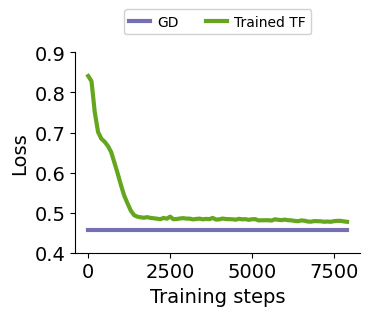

In [8]:
print([float(x) for x in loss_trans_list[0]])
print("---p_norm_list")
print([float(x) for x in losses_gd_list[0]])   
# print(loss_trans_list[0][-1])
# print(losses_gd_list[0][-1])
display_learning(loss_trans_list, test=losses_gd_list, y_lim_u=0.9, y_lim_l=0.4,
                 rw=1, title="train_loss_layer1_doc2_dim10_R_all_0.pdf", allow_download=True,   
                 title1='Trained TF', title2='GD', single_seeds=True,second_axis=False,
                 num_iter_os=len(loss_trans_list[0])*100)

# 0.5139412879943848
# 2:
# 0.56672347
# 0.56188846
"""
# 2:
# 0.56672347
# 0.56188846
5:
0.571959
0.56197524

10
0.5745692
0.56199145

15
0.57516754
0.56204414

25;

0.5765719
0.56224084

"""

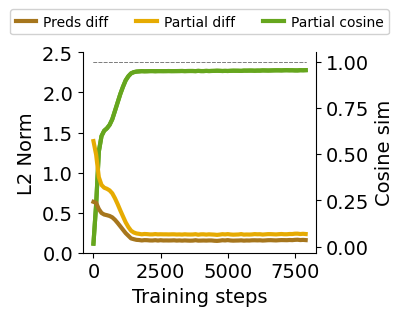

In [9]:
display_learning(cos_sim_list_o, grad_norm_list, p_norm_list, title1="Partial cosine",
                 title2="Partial diff", y_lim_u=2.5,
                 title3="Preds diff", second_axis=True,
                 y_lim_u2=1,  color_add=0.2, loc_sec = 'lower left',
                 y_lim_l2=0.8,
                 rw=1, num_iter_os=len(cos_sim_list[0])*100, title="sim_layer1_doc2_dim10_R_w_all_0.pdf",
                 allow_download=True)

In [10]:

print([float(x) for x in cos_sim_list[0]])
print("-----------")
print([float(x) for x in grad_norm_list[0]])
print("-----------")

print([float(x) for x in p_norm_list[0]])

[0.01488451473414898, 0.24034516513347626, 0.5463016629219055, 0.632989227771759, 0.6605537533760071, 0.6715195775032043, 0.6877228021621704, 0.7162724137306213, 0.7608907222747803, 0.8077932000160217, 0.8523134589195251, 0.8895808458328247, 0.9207809567451477, 0.9414463639259338, 0.9546831846237183, 0.9598259329795837, 0.9621407985687256, 0.9631851315498352, 0.9642993807792664, 0.9634947180747986, 0.9638466835021973, 0.9644044637680054, 0.9644529819488525, 0.9637818336486816, 0.9644536972045898, 0.9642395973205566, 0.9643325805664062, 0.964299201965332, 0.9646262526512146, 0.9643584489822388, 0.9643864035606384, 0.9647175669670105, 0.964537501335144, 0.964845597743988, 0.9643481969833374, 0.9646847248077393, 0.9647567868232727, 0.9646455645561218, 0.9640781283378601, 0.9652612805366516, 0.9642566442489624, 0.9643917679786682, 0.965015709400177, 0.9643441438674927, 0.9647429585456848, 0.9649603962898254, 0.9655185341835022, 0.9649274945259094, 0.9641247987747192, 0.9644367098808289, 0.

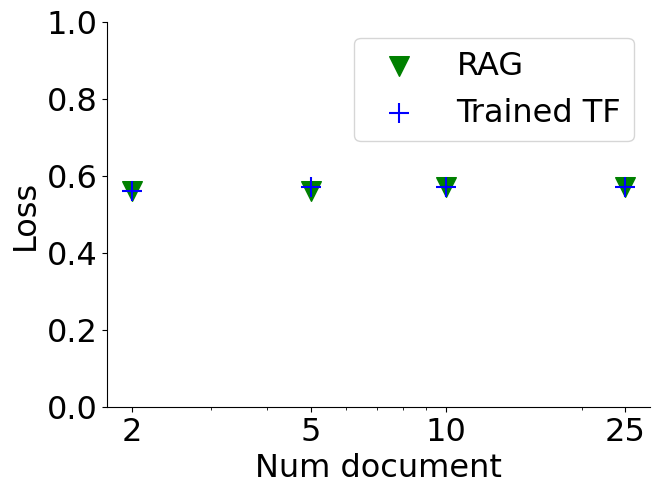

In [11]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 23})
 
x = [2, 5, 10, 25]
 

"""


"""
loss_trans = [0.56,0.57,0.57,0.57]  
losses_gds = [0.56,0.56,0.57,0.57]  

plt.figure(figsize=(7,5))
plt.ylim(0, 1)
 
plt.scatter(x, losses_gds, marker="v", color="green", s=200, label="RAG")
plt.scatter(x, loss_trans, marker="+", color="blue", s=200, label="Trained TF")

 
plt.xscale("log")
plt.xticks(x, labels=[str(i) for i in x])  # 显式显示你的横坐标点

 
plt.xlabel("Num document",fontsize=23)
plt.ylabel("Loss",fontsize=23)
# plt.title("Comparison of GD and Trained Transformer")
plt.legend()
plt.grid(False)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# plt.scatter(x, losses_gds, marker="v", color="green", s=80, label="RAG")
# plt.scatter(x, loss_trans, marker="+", color="blue", s=100, label="Trained TF")
plt.savefig("R2_different_doc.pdf",format="pdf", bbox_inches="tight")
plt.show()

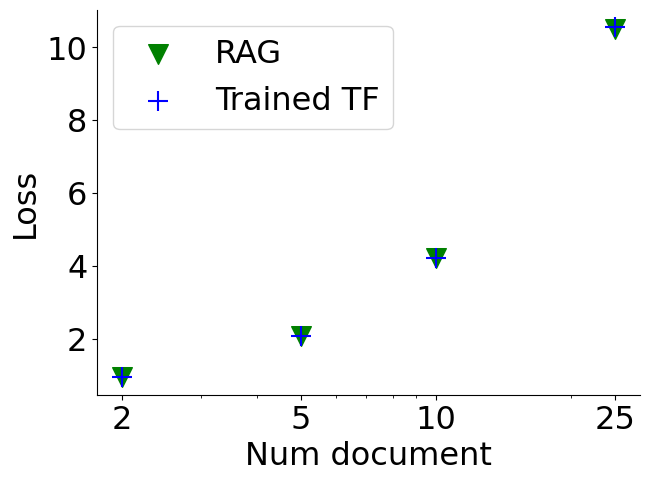

In [12]:

"""----R1"""
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 23})
 
x = [2, 5, 10, 25]

 
loss_trans = [0.94,2.08,4.20,10.55] 
losses_gds = [0.94,2.08,4.20,10.50]

plt.figure(figsize=(7,5))

 
plt.scatter(x, losses_gds, marker="v", color="green", s=200, label="RAG")
plt.scatter(x, loss_trans, marker="+", color="blue", s=200, label="Trained TF")

 
plt.xscale("log")
plt.xticks(x, labels=[str(i) for i in x])   

 
plt.xlabel("Num document",fontsize=23)
plt.ylabel("Loss",fontsize=23)
# plt.title("Comparison of GD and Trained Transformer")
plt.legend()
plt.grid(False)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.savefig("R1_different_doc.pdf",format="pdf", bbox_inches="tight")
plt.show()

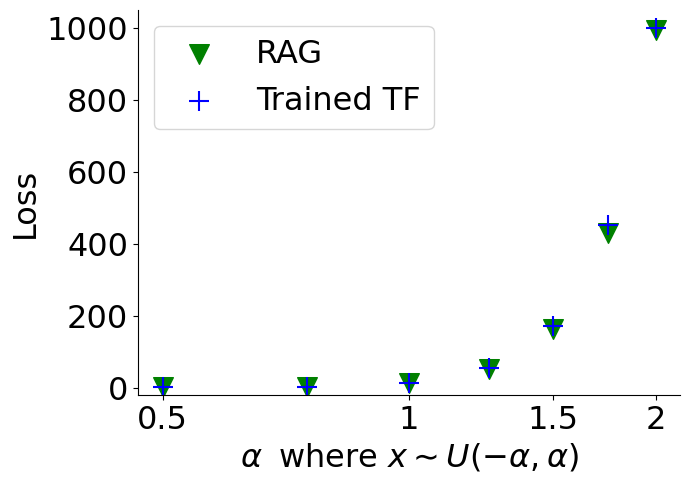

In [13]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter, NullLocator

x = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]
loss_trans = [0.56,2.30,12.60,53.20,170.90,452.71,1000]   # 1043.43
losses_gds = [0.57,2.26,12.20,50.72,162.59,430.49,995]  # 992.1

plt.figure(figsize=(7,5))

plt.scatter(x, losses_gds, marker="v", color="green", s=200, label="RAG")
plt.scatter(x, loss_trans, marker="+", color="blue", s=200, label="Trained TF")
plt.ylim(-20, 1050)
ax = plt.gca()
ax.set_xscale("log")

 
ticks = [0.5, 1, 1.5, 2]
ax.xaxis.set_major_locator(FixedLocator(ticks))
ax.xaxis.set_major_formatter(FixedFormatter(['0.5', '1', '1.5', '2']))
ax.xaxis.set_minor_locator(NullLocator())   

plt.xlabel(r"$\alpha \;\;\text{where } x \sim U(-\alpha, \alpha)$", fontsize=23)
plt.ylabel("Loss", fontsize=23)
# plt.plot(x, y, marker="o", label=r"$\alpha \;\;\text{where } x \sim U(-\alpha, \alpha)$")
plt.legend()
plt.grid(False)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.savefig("R2_out_distrubtion.pdf", format="pdf", bbox_inches="tight")
plt.show()


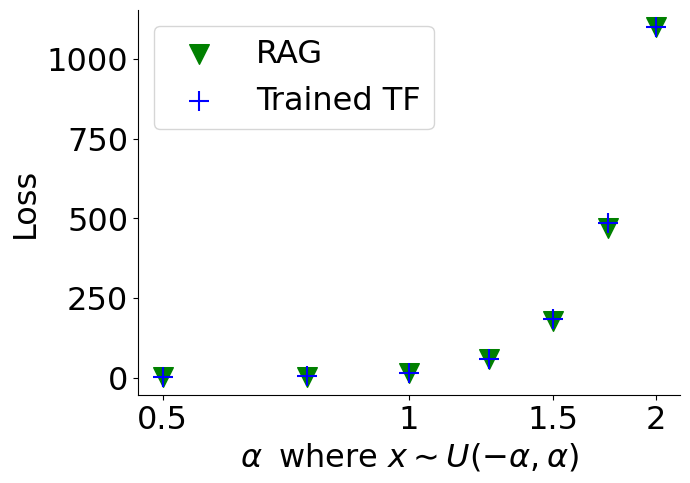

In [14]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter, NullLocator

x = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]
loss_trans = [0.94,3.23,14.89,58.76,184.73,485.17,1100]    
losses_gds = [0.94,3.16,14.39,56.70,178.29,468.50,1100]   

plt.figure(figsize=(7,5))

plt.scatter(x, losses_gds, marker="v", color="green", s=200, label="RAG")
plt.scatter(x, loss_trans, marker="+", color="blue", s=200, label="Trained TF")

ax = plt.gca()
ax.set_xscale("log")

# 只显示 0.5, 1, 1.5, 2
ticks = [0.5, 1, 1.5, 2]
ax.xaxis.set_major_locator(FixedLocator(ticks))
ax.xaxis.set_major_formatter(FixedFormatter(['0.5', '1', '1.5', '2']))
ax.xaxis.set_minor_locator(NullLocator())   

plt.xlabel(r"$\alpha \;\;\text{where } x \sim U(-\alpha, \alpha)$", fontsize=23)
plt.ylabel("Loss", fontsize=23)
plt.legend()
plt.grid(False)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.savefig("R1_out_distrubtion.pdf", format="pdf", bbox_inches="tight")
plt.show()


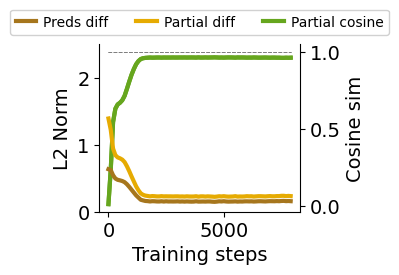

In [15]:
display_learning(cos_sim_list, grad_norm_list, p_norm_list, title1="Partial cosine",
                 title2="Partial diff", y_lim_u=2.5,
                 title3="Preds diff", second_axis=True,
                 y_lim_u2=1,  color_add=0.2, loc_sec = 'lower left',
                 y_lim_l2=0.8,
                 rw=1, num_iter_os=len(cos_sim_list[0])*100, title="sim_layer1_doc2_dim10_R_w_all_0.pdf",
                 allow_download=True)

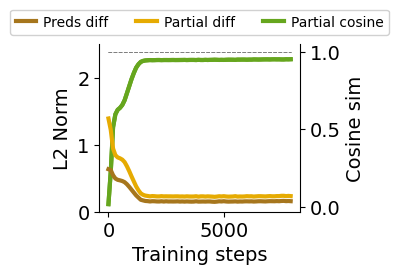

In [16]:
display_learning(cos_sim_list_o, grad_norm_list, p_norm_list, title1="Partial cosine",
                 title2="Partial diff", y_lim_u=2.5,
                 title3="Preds diff", second_axis=True,
                 y_lim_u2=1,  color_add=0.2, loc_sec = 'lower left',
                 y_lim_l2=0.8,
                 rw=1, num_iter_os=len(cos_sim_list[0])*100, title="sim_cos_pre_layer1_doc5_dim10_5000_GD++.pdf",
                 allow_download=True)